In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
np.random.seed(1)

In [74]:
requests = pd.read_csv('requests_every_hour.csv', header=0)

requests.head()

,Requests
0,100
1,113
2,162
3,186
4,228


In [75]:
len(requests)

840

In [76]:
requests.shape

(840, 1)

In [77]:
requests.info

<bound method DataFrame.info of      Requests
0         100
1         113
2         162
3         186
4         228
..        ...
835       122
836       108
837        51
838        68
839        41

[840 rows x 1 columns]>

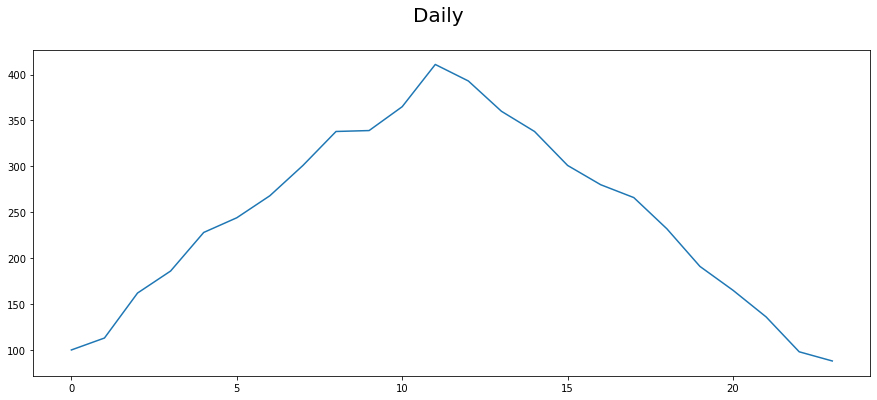

In [78]:
# plot the data loaded to vizualize trends
# daily
plt.figure(figsize=(15,6)).suptitle("Daily", fontsize=20)
plt.plot(requests.head(24))
plt.show()

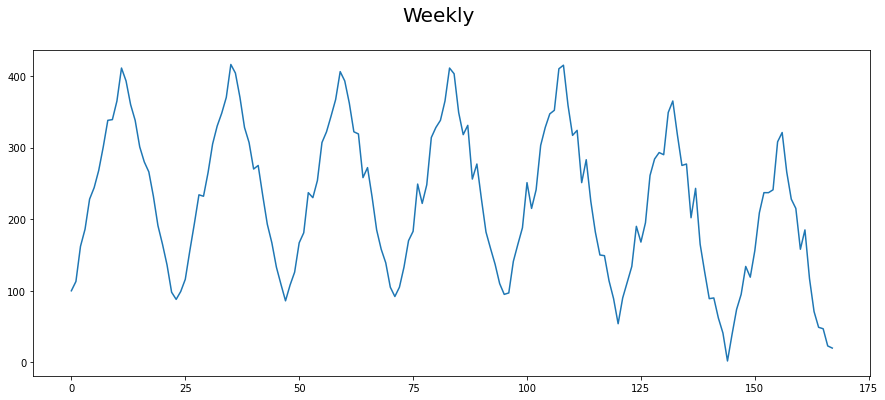

In [79]:
# Weekly
plt.figure(figsize=(15,6)).suptitle("Weekly", fontsize=20)
plt.plot(requests.head(168))
plt.show()

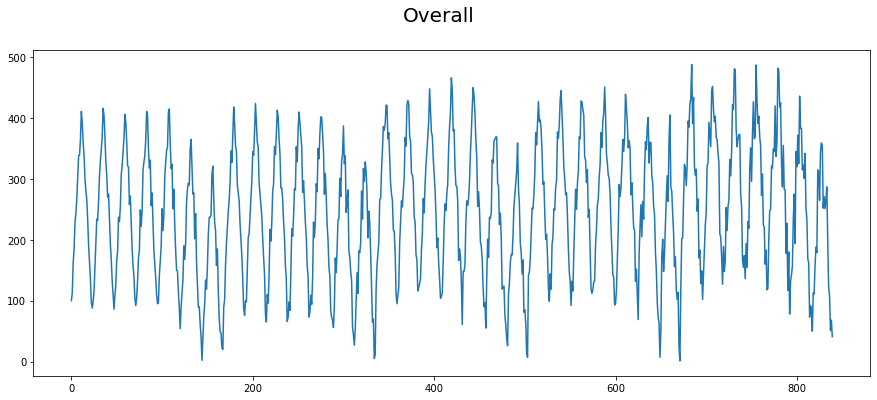

In [80]:
# overall
plt.figure(figsize=(15,6)).suptitle("Overall", fontsize=20)
plt.plot(requests)
plt.show()

In [81]:
from sklearn.preprocessing import StandardScaler

# scale the data
print("Request range before scaling: ", min(requests.Requests), max(requests.Requests))

Request range before scaling:  1 488


In [82]:
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request range after scaling: ", min(scaled_requests), max(scaled_requests))

Request range after scaling:  [-2.28221282] [2.23748868]


In [83]:
# Training data has to be sequencial - first 4 weeks
train_size = 24 * 7 * 4

# Number of samples to lookback for each sample
lookback= 24 * 7

#Separate training and test data
train_requests = scaled_requests[0:train_size,:]

# adding an additional week for lookback
test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of train, Test: ", train_requests.shape, test_requests.shape)


 Shaped of train, Test:  (672, 1) (336, 1)


In [84]:
# Prepare RNN Dataset

def create_rnn_dataset(data, lookback=1):
    data_x, data_y = [], []
    for i in range(len(data)-lookback-1):
        a = data[i:(i+lookback),0]
        data_x.append(a)
        data_y.append(data[i+lookback,0])
    return np.array(data_x), np.array(data_y)

In [85]:
# Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(train_requests, lookback)

In [86]:
train_req_x.shape

(503, 168)

In [87]:
# Reshape for use with LSTM 3D
train_req_x = np.reshape(train_req_x, (train_req_x.shape[0], 1, train_req_x.shape[1]))

In [88]:
print("Shape of X, Y: ", train_req_x.shape, train_req_y.shape)

Shape of X, Y:  (503, 1, 168) (503,)


In [89]:
# Build LSTM Model

from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

tf.random.set_seed(3)

In [90]:
ts_model = Sequential()
ts_model.add(LSTM(256, input_shape=(1, lookback)))
ts_model.add(Dense(1))

# Compile with adam optimizer. Optimize for minimum mean square error
ts_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [91]:
ts_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               435200    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 435457 (1.66 MB)
Trainable params: 435457 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
ts_model.fit(train_req_x, train_req_y, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
503/503 [==============================] - 6s 8ms/step - loss: 0.1596 - mse: 0.1596
Epoch 2/5
503/503 [==============================] - 4s 8ms/step - loss: 0.0775 - mse: 0.0775
Epoch 3/5
503/503 [==============================] - 4s 8ms/step - loss: 0.0659 - mse: 0.0659
Epoch 4/5
503/503 [==============================] - 4s 8ms/step - loss: 0.0506 - mse: 0.0506
Epoch 5/5
503/503 [==============================] - 4s 8ms/step - loss: 0.0535 - mse: 0.0535


In [93]:
# Test the model
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_requests, lookback)
test_req_x = np.reshape(test_req_x, (test_req_x.shape[0], 1, test_req_x.shape[1]))

ts_model.evaluate(test_req_x, test_req_y, verbose=1)


6/6 [==============================] - 1s 5ms/step - loss: 0.1575 - mse: 0.1575


[0.15746398270130157, 0.15746398270130157]

In [94]:
#Predict for training dataset
predict_on_train = ts_model.predict(train_req_x)
#Predict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

6/6 [==============================] - 0s 4ms/step


In [95]:
# inverse scaling
predict_on_test = scaler.inverse_transform(predict_on_test)
predict_on_train = scaler.inverse_transform(predict_on_train)
print(predict_on_test[0:5,:])

[[ 55.734795]
 [ 68.53922 ]
 [120.27786 ]
 [202.12544 ]
 [256.40323 ]]


In [96]:
# Plot the prediction

# total size
total_size = len(predict_on_train) + len(predict_on_test)

In [97]:
# plot original data
# reshape the data into single column
orig_data = requests.Requests.to_numpy()
orig_data = orig_data.reshape(len(orig_data), 1)

In [98]:
# Create a plot for original data
orig_plot = np.empty((total_size, 1))
orig_plot[:,:] = np.nan
orig_plot[0:total_size,:] = orig_data[lookback:-2,]
print(orig_plot[0:5,:])

[[ 90.]
 [102.]
 [159.]
 [194.]
 [219.]]


In [99]:
#Create a plot for predictions on training
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

print(predict_train_plot[0:5,:])

[[ 50.11493683]
 [ 71.91246796]
 [116.1166153 ]
 [182.75823975]
 [225.75660706]]


In [100]:
#Create a plot for predictions on testing
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test

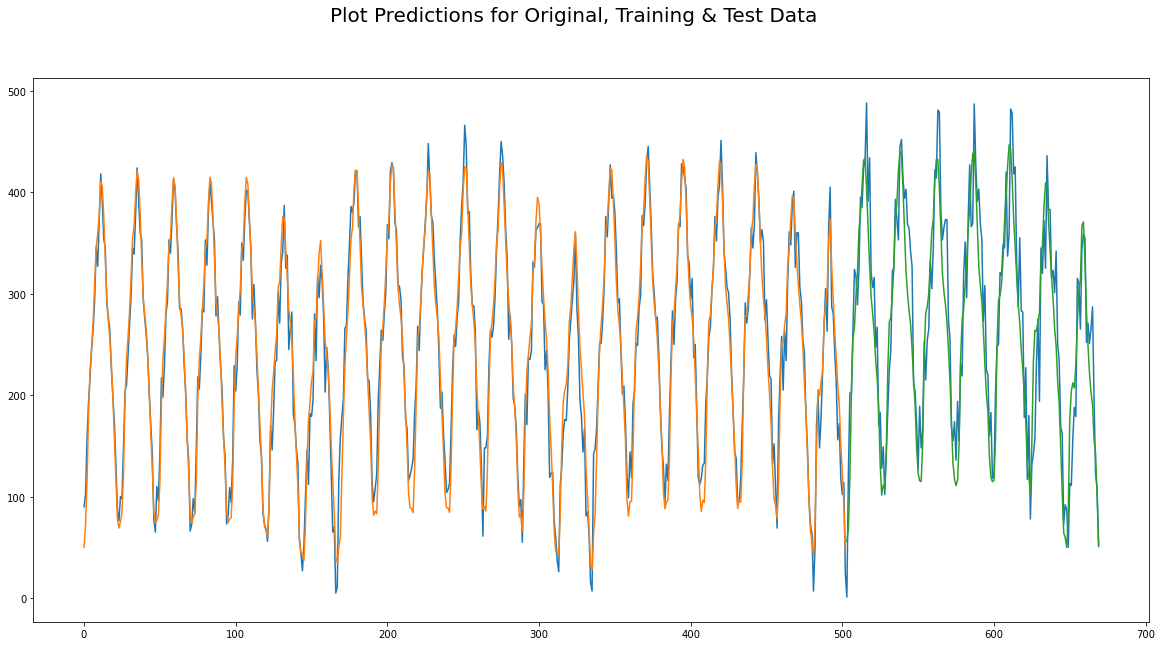

In [101]:
#Plot the graphs
plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original, Training & Test Data", fontsize=20)
plt.plot(orig_plot)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()

In [103]:
# Forecasting future service loads 
# code sets last row of test_req_x data. it's flattened to make it one dimensional array
curr_input = test_req_x[-1,:].flatten()

In [104]:
# predict for next week
predict_for = 24*7

for i in range(predict_for):
    
    #Take the last lookback no. of samples as X
    this_input=curr_input[-lookback:]
    #Create the input
    this_input=this_input.reshape((1,1,lookback))
    #Predict for the next point
    this_prediction=ts_model.predict(this_input)

    #Add the current prediction to the input
    curr_input = np.append(curr_input,this_prediction.flatten())

#Extract the last predict_for part of curr_input, which contains all the new predictions
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

# #Inverse to view results
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])
    

1/1 [==============================] - 0s 29ms/step
[[ 52.85350674]
 [ 53.54729605]
 [ 74.49358581]
 [ 87.63550684]
 [146.33501787]]


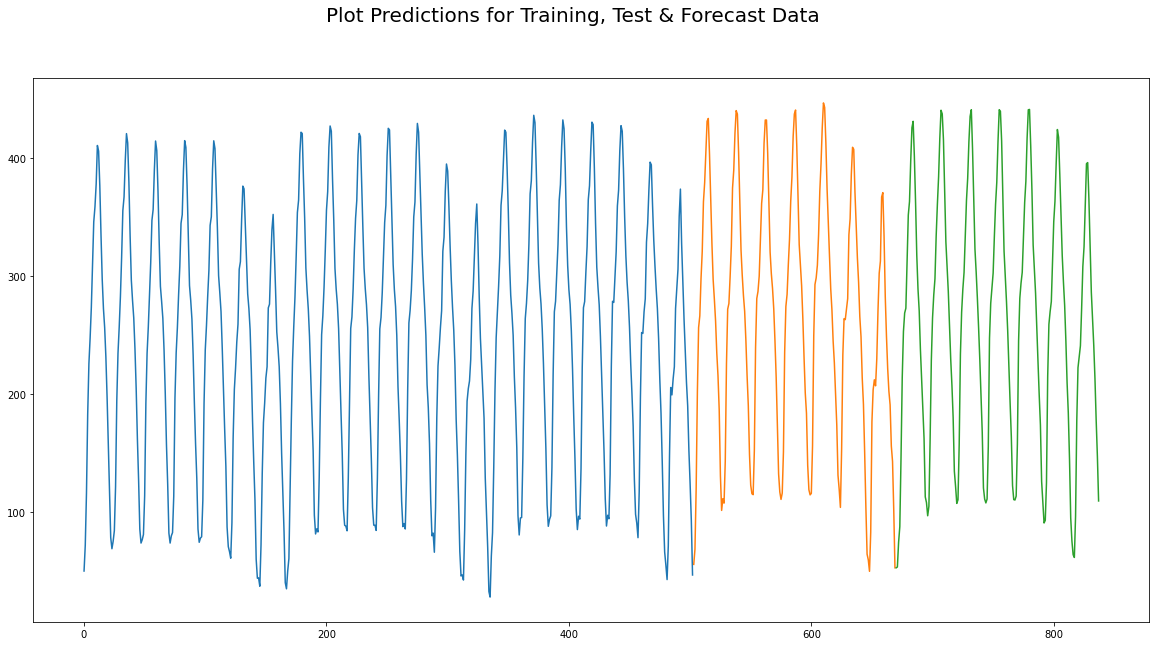

In [105]:
#Plot the training data with the forecast data
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

#Setup training chart
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Setup test chart
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test

#Setup future forecast chart
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data", fontsize=20)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.plot(predict_future_plot)
plt.show()